In [4]:
# Yitian block
import os
import sys
sys.path.append("..")

import numpy as np
import healpy as hp

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import jax.scipy.optimize as optimize
from jax.scipy.stats.multivariate_normal import logpdf
from jax.example_libraries import stax

import optax
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, autoguide, TraceMeanField_ELBO
from numpyro.infer.elbo import Trace_ELBO_2
from numpyro.infer.reparam import NeuTraReparam
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.tfp.mcmc import ReplicaExchangeMC
from tensorflow_probability.substrates import jax as tfp

from utils import create_mask as cm
from utils.sph_harm import Ylm
from utils.map_utils import to_nside
from utils import ed_fcts as ef

from templates.rigid_templates import EbinTemplate, Template, BulgeTemplates
from templates.variable_templates import NFWTemplate, LorimerDiskTemplate
from likelihoods.pll_jax import log_like_poisson

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

import astropy.io
from astropy.io import fits
from utils.map_utils import to_nside

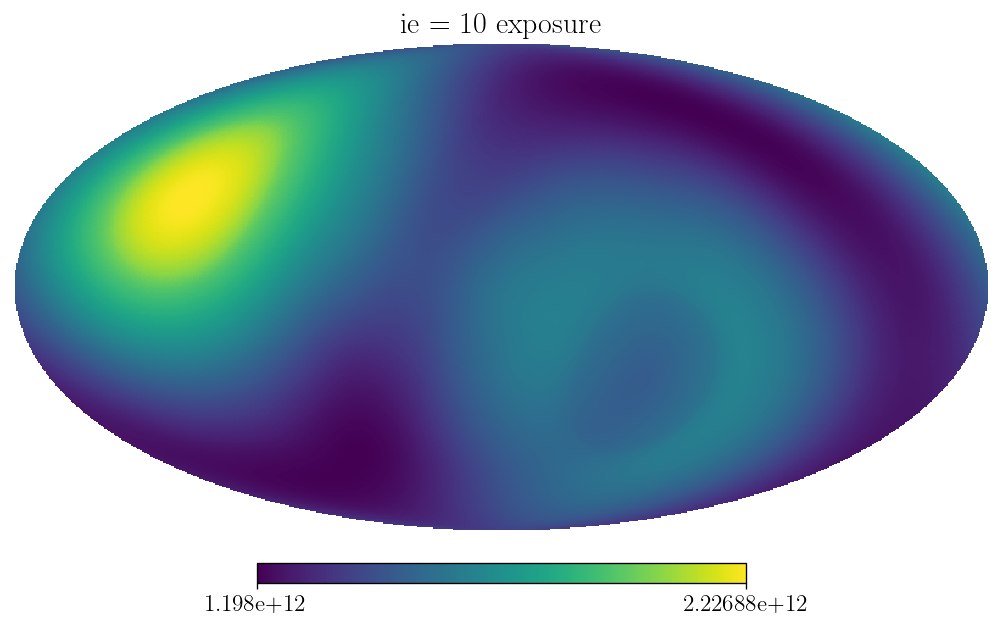

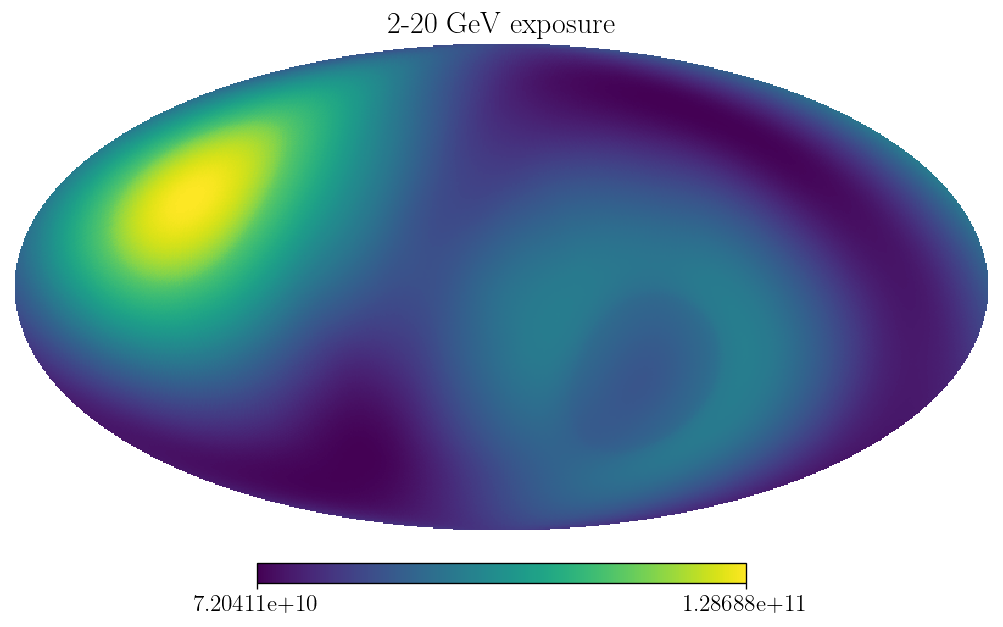

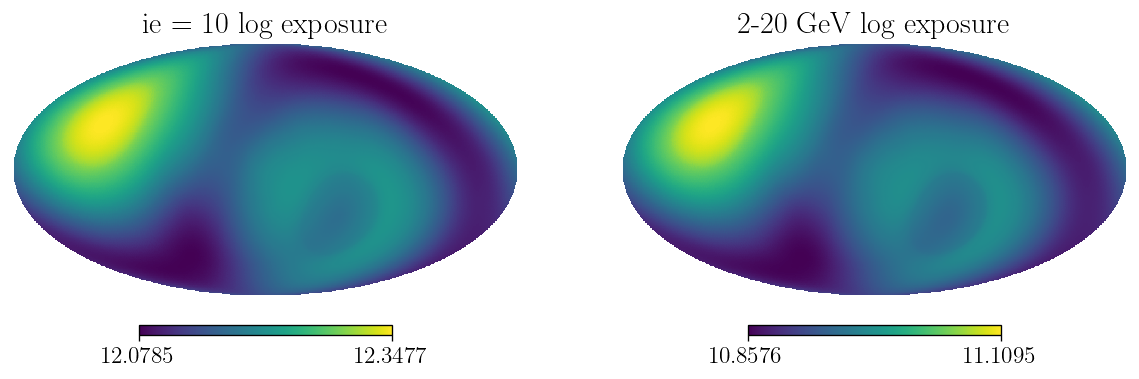

In [5]:
# load old exposure map
nside = 128
old_exposure = to_nside(
            np.load('../data/fermi_data_573w/ebin_128/exposure-fwhm000-0512-bestpsf-nopsc.npy'),
            nside,
            mode='sum',
        )
hp.mollview(old_exposure[10], title="ie = 10 exposure")

# load new 2 - 20 GeV exposure to apply to psc templates
exposure = to_nside(
            np.load('../data/fermi_data_573w/fermi_data_128/fermidata_exposure.npy'),
            nside,
            mode='sum',
        )
hp.mollview(exposure, title="2-20 GeV exposure")

fig, (ax1, ax2) = plt.subplots(figsize = (12,6), ncols=2)
plt.axes(ax1)
hp.mollview(np.log10(old_exposure[10]), title="ie = 10 log exposure", hold = True)

plt.axes(ax2)
hp.mollview(np.log10(exposure), title="2-20 GeV log exposure", hold = True)


In [6]:
# load exposure to apply to psc templates
# compare different masking

# create templates (note exposure multiplication of Tracy's templates)
temp_gcenn = np.load("../data/fermi_data_573w/fermi_data_128/template_psc_4fgl.npy")
temp_dr1 = exposure * np.array(
    fits.open('../data/fermi_data_573w/fermi_data_128/4FGL-DR1_eventclass=ULTRACLEANVETO_eventtype=3_2-20GeV.fits')[0].data)
temp_dr2 = exposure * np.array(
    fits.open('../data/fermi_data_573w/fermi_data_128/4FGL-DR2_eventclass=ULTRACLEANVETO_eventtype=3_2-20GeV.fits')[0].data)
temp_dr4 = exposure * np.array(
    fits.open('../data/fermi_data_573w/fermi_data_128/4FGL-DR4_eventclass=ULTRACLEANVETO_eventtype=3_2-20GeV.fits')[0].data)

In [7]:
# save templates as energy-dependent templates
temp_dr1_fin = np.tile(temp_dr1, (40,1))
temp_dr2_fin = np.tile(temp_dr2, (40,1))
temp_dr4_fin = np.tile(temp_dr4, (40,1))

# save summed templates
np.save("../data/fermi_data_573w/ebin_128/tracy-psc-bestpsf-4fgl-dr1", temp_dr1_fin)
np.save("../data/fermi_data_573w/ebin_128/tracy-psc-bestpsf-4fgl-dr2", temp_dr2_fin)
np.save("../data/fermi_data_573w/ebin_128/tracy-psc-bestpsf-4fgl-dr4", temp_dr4_fin)

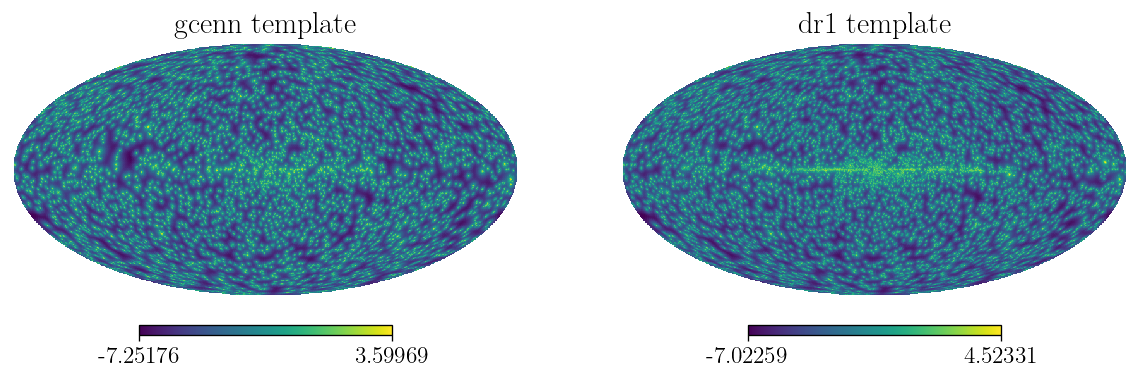

In [8]:
# check that gcenn template agrees with Tracy's dr1 template
fig, (ax1, ax2) = plt.subplots(figsize = (12,6), ncols=2)
plt.axes(ax1)
hp.mollview(np.log10(temp_gcenn), title="gcenn template", hold = True)

plt.axes(ax2)
hp.mollview(np.log10(temp_dr1), title="dr1 template", hold = True)

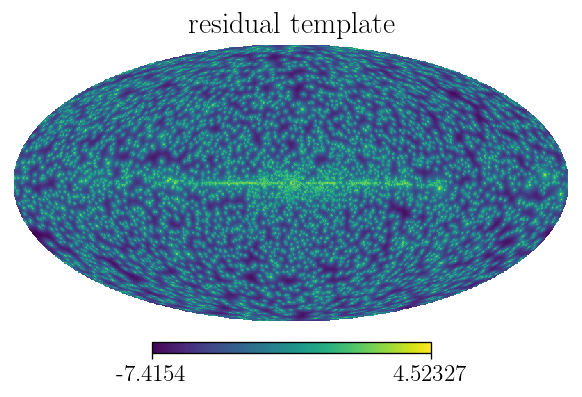

In [9]:
# check that gcenn template agrees with Tracy's dr1 template
hp.mollview(np.log10(np.abs(temp_gcenn - temp_dr1)), title="residual template", hold = True)

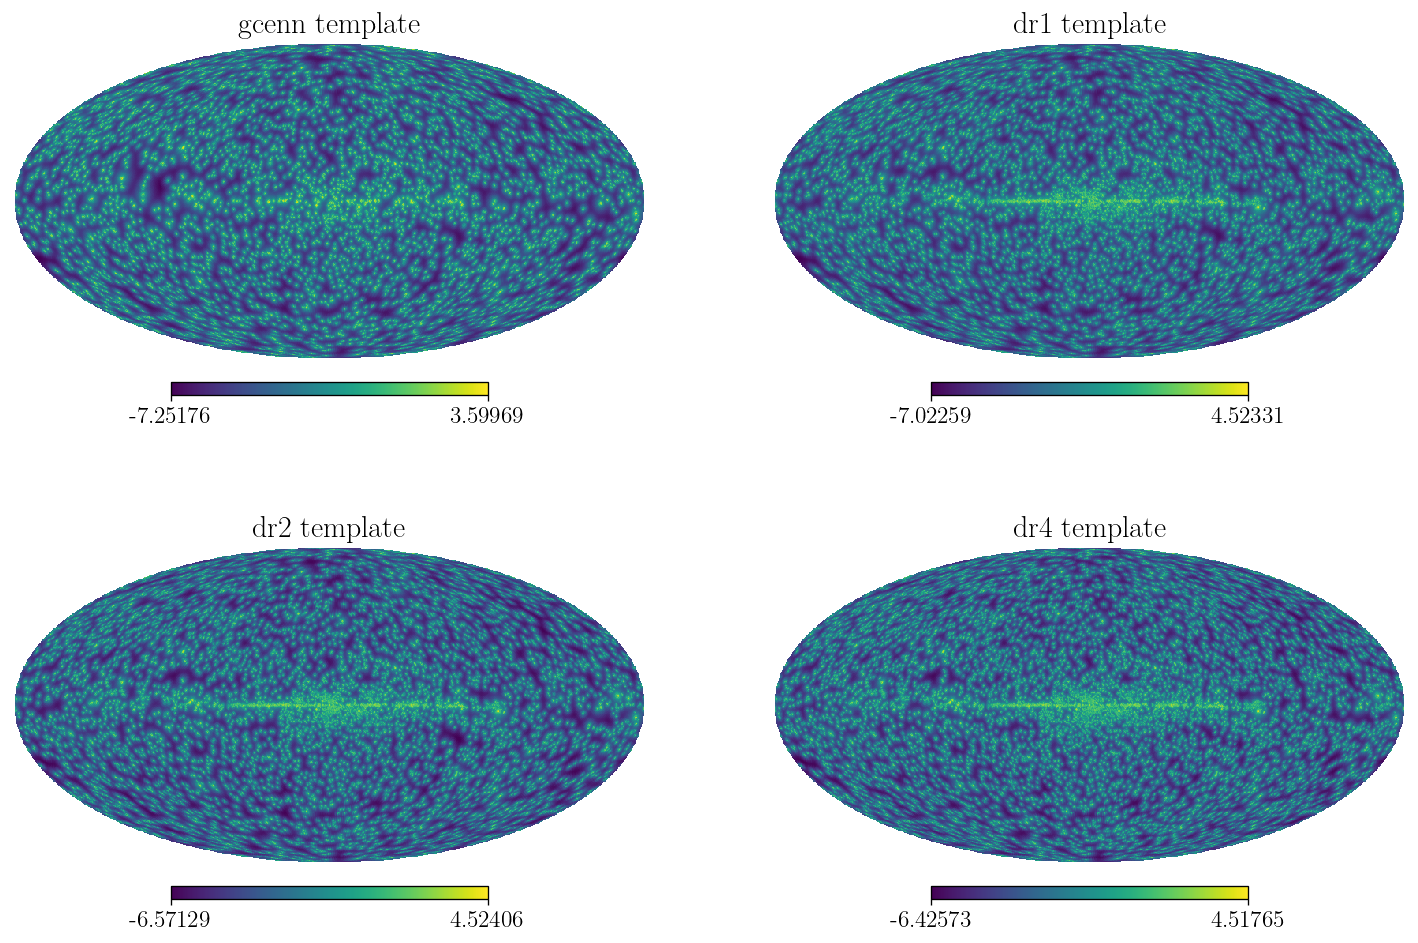

In [10]:
fig, ax_array = plt.subplots(figsize = (15,10), nrows = 2, ncols = 2)

ax1 = ax_array[0,0] ; ax2 = ax_array[0,1] ; ax3 = ax_array[1,0] ; ax4 = ax_array[1,1]

plt.axes(ax1)
hp.mollview(np.log10(temp_gcenn), title="gcenn template", hold = True)

plt.axes(ax2)
hp.mollview(np.log10(temp_dr1), title="dr1 template", hold = True)

plt.axes(ax3)
hp.mollview(np.log10(temp_dr2), title="dr2 template", hold = True)

plt.axes(ax4)
hp.mollview(np.log10(temp_dr4), title="dr4 template", hold = True)

In [11]:
# load masks
mask_dr1_68 = np.array(fits.open('../data/masks/4FGL_DR1_mask_cl=0.680000.fits')[0].data, dtype = np.bool_)
mask_dr2_68 = np.array(fits.open('../data/masks/4FGL_DR2_mask_cl=0.680000.fits')[0].data, dtype = np.bool_)
mask_dr4_68 = np.array(fits.open('../data/masks/4FGL_DR4_mask_cl=0.680000.fits')[0].data, dtype = np.bool_)

mask_dr1_95 = np.array(fits.open('../data/masks/4FGL_DR1_mask_cl=0.950000.fits')[0].data, dtype = np.bool_)
mask_dr2_95 = np.array(fits.open('../data/masks/4FGL_DR2_mask_cl=0.950000.fits')[0].data, dtype = np.bool_)
mask_dr4_95 = np.array(fits.open('../data/masks/4FGL_DR4_mask_cl=0.950000.fits')[0].data, dtype = np.bool_)

mask_dr1_99 = np.array(fits.open('../data/masks/4FGL_DR1_mask_cl=0.990000.fits')[0].data, dtype = np.bool_)
mask_dr2_99 = np.array(fits.open('../data/masks/4FGL_DR2_mask_cl=0.990000.fits')[0].data, dtype = np.bool_)
mask_dr4_99 = np.array(fits.open('../data/masks/4FGL_DR4_mask_cl=0.990000.fits')[0].data, dtype = np.bool_)

mask_dr2_90 = np.array(fits.open('../data/masks/4FGL_DR2_mask_cl=0.900000.fits')[0].data, dtype = np.bool_)

In [12]:
np.save('../data/masks/4FGL_DR1_mask_cl=0.680000.npy', mask_dr1_68)
np.save('../data/masks/4FGL_DR1_mask_cl=0.950000.npy', mask_dr1_95)
np.save('../data/masks/4FGL_DR1_mask_cl=0.990000.npy', mask_dr1_99)

np.save('../data/masks/4FGL_DR2_mask_cl=0.680000.npy', mask_dr2_68)
np.save('../data/masks/4FGL_DR2_mask_cl=0.950000.npy', mask_dr2_95)
np.save('../data/masks/4FGL_DR2_mask_cl=0.990000.npy', mask_dr2_99)

np.save('../data/masks/4FGL_DR4_mask_cl=0.680000.npy', mask_dr4_68)
np.save('../data/masks/4FGL_DR4_mask_cl=0.950000.npy', mask_dr4_95)
np.save('../data/masks/4FGL_DR4_mask_cl=0.990000.npy', mask_dr4_99)

np.save('../data/masks/4FGL_DR2_mask_cl=0.900000.npy', mask_dr2_90)

In [15]:
temp_dr1_68 = ef.convert_masked_array_to_hp_array(temp_dr1[~mask_dr1_68], mask_dr1_68, nside=128)
temp_dr2_68 = ef.convert_masked_array_to_hp_array(temp_dr2[~mask_dr2_68], mask_dr2_68, nside=128)
temp_dr4_68 = ef.convert_masked_array_to_hp_array(temp_dr4[~mask_dr4_68], mask_dr4_68, nside=128)

temp_dr1_95 = ef.convert_masked_array_to_hp_array(temp_dr1[~mask_dr1_95], mask_dr1_95, nside=128)
temp_dr2_95 = ef.convert_masked_array_to_hp_array(temp_dr2[~mask_dr2_95], mask_dr2_95, nside=128)
temp_dr4_95 = ef.convert_masked_array_to_hp_array(temp_dr4[~mask_dr4_95], mask_dr4_95, nside=128)

temp_dr1_99 = ef.convert_masked_array_to_hp_array(temp_dr1[~mask_dr1_99], mask_dr1_99, nside=128)
temp_dr2_99 = ef.convert_masked_array_to_hp_array(temp_dr2[~mask_dr2_99], mask_dr2_99, nside=128)
temp_dr4_99 = ef.convert_masked_array_to_hp_array(temp_dr4[~mask_dr4_99], mask_dr4_99, nside=128)

temp_dr2_90 = ef.convert_masked_array_to_hp_array(temp_dr2[~mask_dr2_90], mask_dr2_90, nside=128)

In [19]:
np.max(temp_dr2[~mask_dr2_90])

1548.7770410403925

/tmp/ipykernel_2441052/1984073746.py:6: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr2_90), title="dr2 template w 0.90 masks", hold = True)
/tmp/ipykernel_2441052/1984073746.py:9: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr2_68), title="dr2 template w 0.68 masks", hold = True)
/tmp/ipykernel_2441052/1984073746.py:12: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr2_95), title="dr2 template w 0.95 masks", hold = True)
/tmp/ipykernel_2441052/1984073746.py:15: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr2_99), title="dr2 template w 0.99 masks", hold = True)


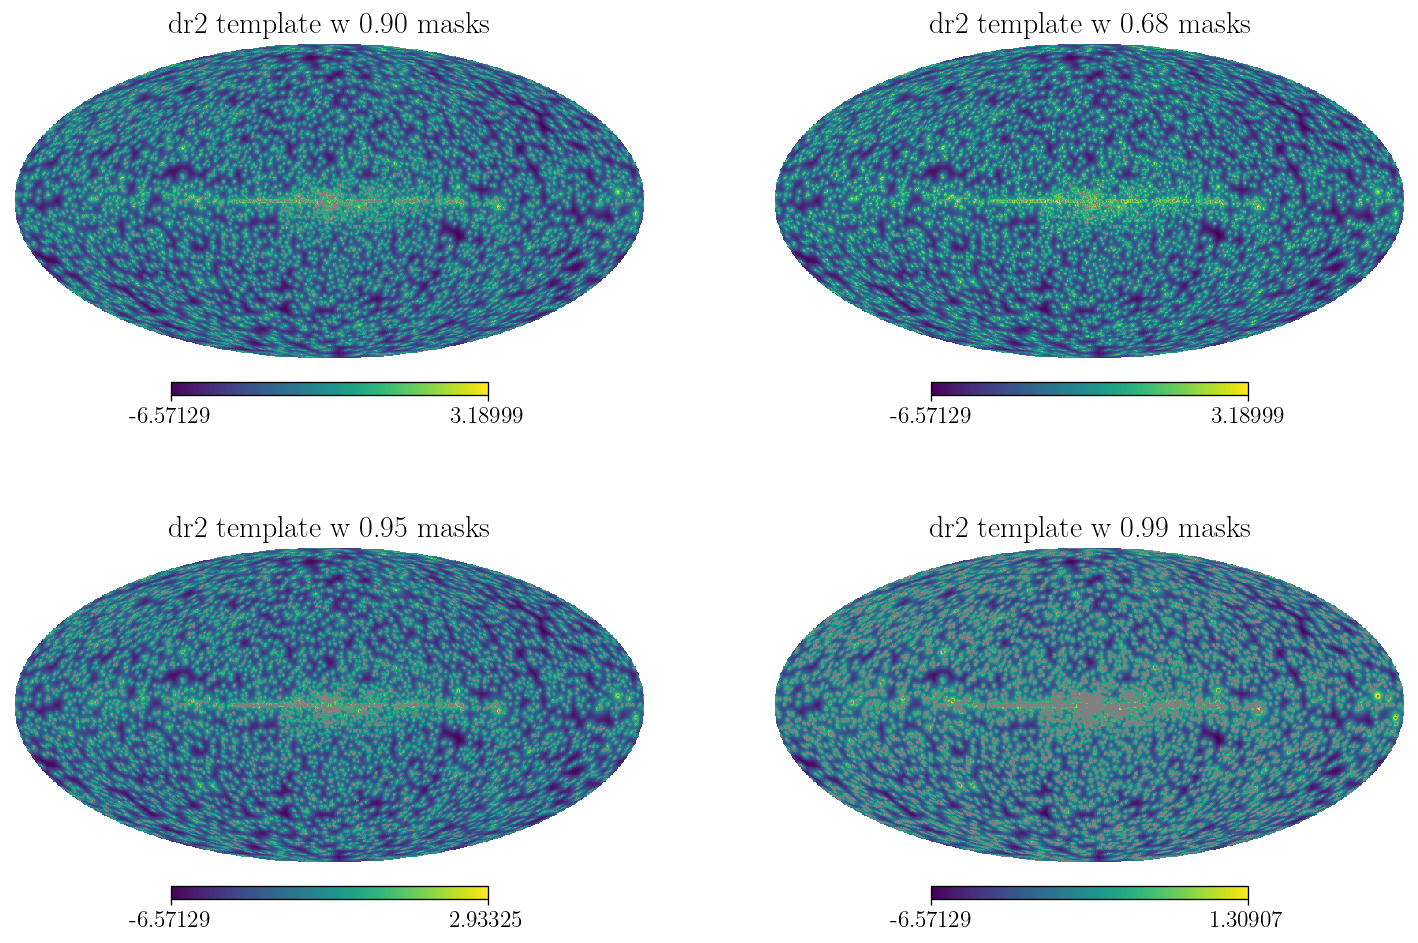

In [20]:
fig, ax_array = plt.subplots(figsize = (15,10), nrows = 2, ncols = 2)

ax1 = ax_array[0,0] ; ax2 = ax_array[0,1] ; ax3 = ax_array[1,0] ; ax4 = ax_array[1,1]

plt.axes(ax1)
hp.mollview(np.log10(temp_dr2_90), title="dr2 template w 0.90 masks", hold = True)

plt.axes(ax2)
hp.mollview(np.log10(temp_dr2_68), title="dr2 template w 0.68 masks", hold = True)

plt.axes(ax3)
hp.mollview(np.log10(temp_dr2_95), title="dr2 template w 0.95 masks", hold = True)

plt.axes(ax4)
hp.mollview(np.log10(temp_dr2_99), title="dr2 template w 0.99 masks", hold = True)

In [13]:
temp_gcenn_95 = ef.convert_masked_array_to_hp_array(temp_gcenn[~mask_gcenn_95], mask_gcenn_95, nside=128)
temp_dr1_68 = ef.convert_masked_array_to_hp_array(temp_dr1[~mask_dr1_68], mask_dr1_68, nside=128)
temp_dr2_68 = ef.convert_masked_array_to_hp_array(temp_dr2[~mask_dr2_68], mask_dr2_68, nside=128)
temp_dr4_68 = ef.convert_masked_array_to_hp_array(temp_dr4[~mask_dr4_68], mask_dr4_68, nside=128)

temp_dr1_95 = ef.convert_masked_array_to_hp_array(temp_dr1[~mask_dr1_95], mask_dr1_95, nside=128)
temp_dr2_95 = ef.convert_masked_array_to_hp_array(temp_dr2[~mask_dr2_95], mask_dr2_95, nside=128)
temp_dr4_95 = ef.convert_masked_array_to_hp_array(temp_dr4[~mask_dr4_95], mask_dr4_95, nside=128)

temp_dr1_99 = ef.convert_masked_array_to_hp_array(temp_dr1[~mask_dr1_99], mask_dr1_99, nside=128)
temp_dr2_99 = ef.convert_masked_array_to_hp_array(temp_dr2[~mask_dr2_99], mask_dr2_99, nside=128)
temp_dr4_99 = ef.convert_masked_array_to_hp_array(temp_dr4[~mask_dr4_99], mask_dr4_99, nside=128)

NameError: name 'mask_gcenn_95' is not defined

In [87]:
len(np.where(mask_gcenn_95 == 1)[0])

16086

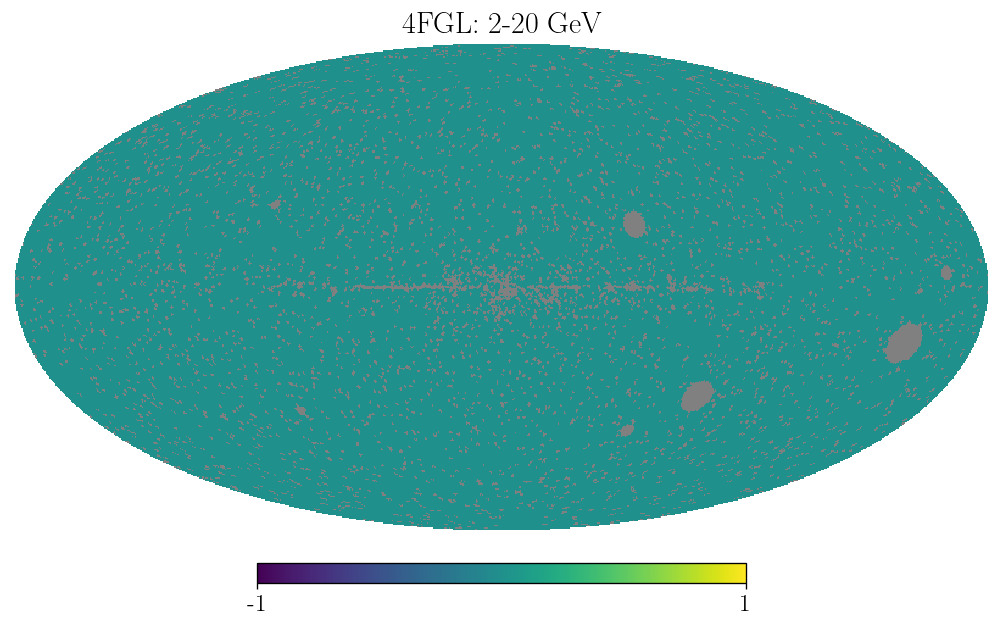

In [88]:
temp_4fgl = np.load("../data/fermi_data_573w/fermi_data_128/template_psc_4fgl.npy")
mask_4fgl = np.load('../data/fermi_data_573w/fermi_data_128/fermidata_pscmask_4fgl.npy')
temp_4fgl_hp = ef.convert_masked_array_to_hp_array(temp_4fgl[~mask_4fgl], mask_4fgl, nside=128)
hp.mollview(temp_4fgl_hp, title="4FGL: 2-20 GeV")

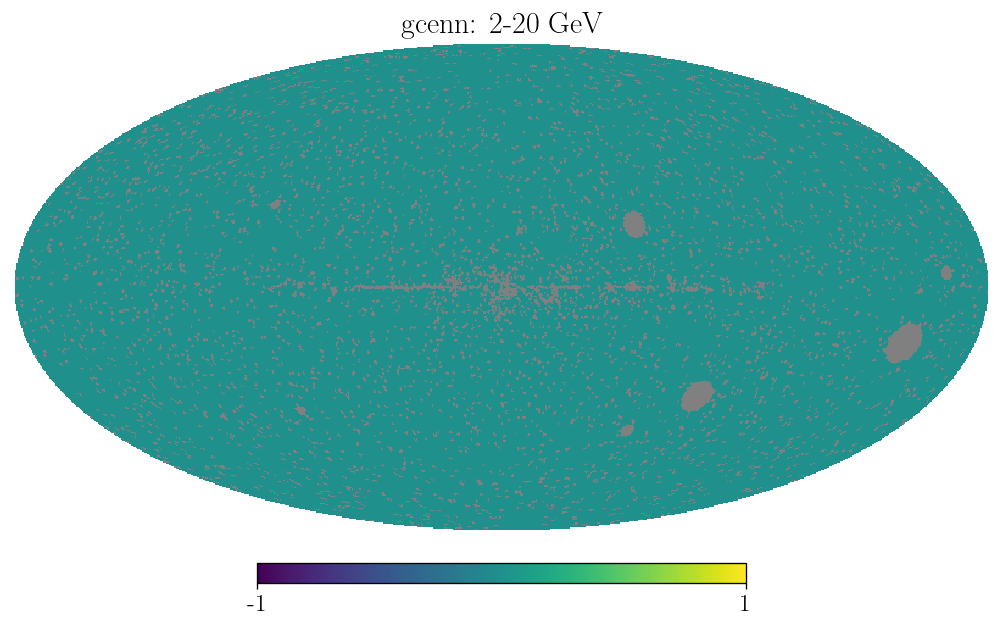

In [89]:
hp.mollview(temp_gcenn_95, title="gcenn: 2-20 GeV")

/tmp/ipykernel_1652609/1606872602.py:9: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr1_95), title="dr1 template w 0.95 masks", hold = True)
/tmp/ipykernel_1652609/1606872602.py:12: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr2_95), title="dr2 template w 0.95 masks", hold = True)
/tmp/ipykernel_1652609/1606872602.py:15: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr4_95), title="dr4 template w 0.95 masks", hold = True)


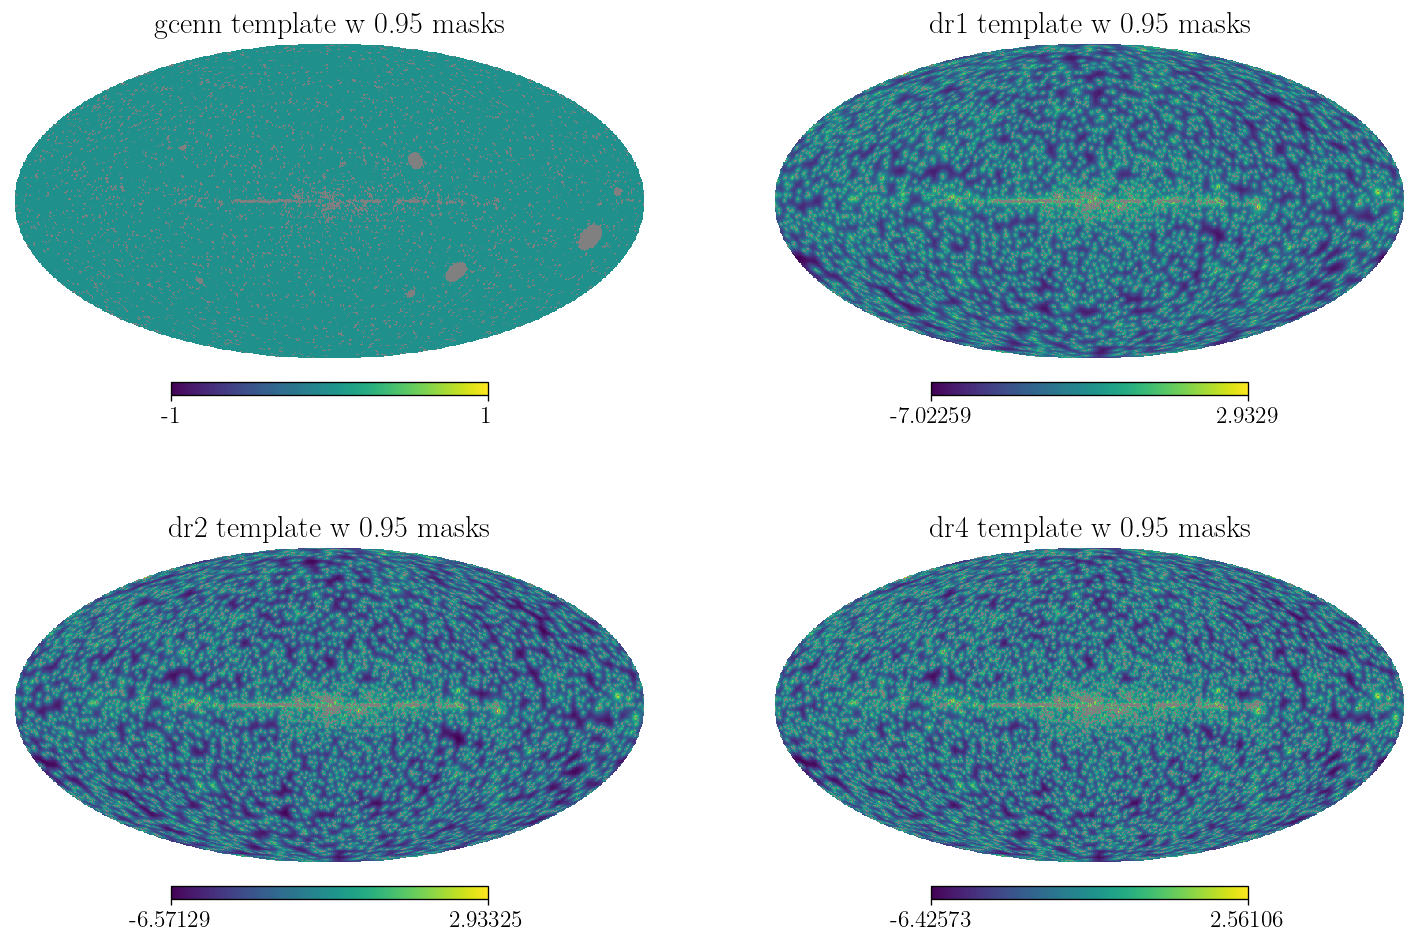

In [93]:
fig, ax_array = plt.subplots(figsize = (15,10), nrows = 2, ncols = 2)

ax1 = ax_array[0,0] ; ax2 = ax_array[0,1] ; ax3 = ax_array[1,0] ; ax4 = ax_array[1,1]

plt.axes(ax1)
hp.mollview(temp_gcenn_95, title="gcenn template w 0.95 masks", hold = True)

plt.axes(ax2)
hp.mollview(np.log10(temp_dr1_95), title="dr1 template w 0.95 masks", hold = True)

plt.axes(ax3)
hp.mollview(np.log10(temp_dr2_95), title="dr2 template w 0.95 masks", hold = True)

plt.axes(ax4)
hp.mollview(np.log10(temp_dr4_95), title="dr4 template w 0.95 masks", hold = True)

/tmp/ipykernel_1652609/1489189897.py:10: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr1_99), title="dr1 template w 0.99 masks", hold = True)
/tmp/ipykernel_1652609/1489189897.py:13: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr2_99), title="dr2 template w 0.99 masks", hold = True)
/tmp/ipykernel_1652609/1489189897.py:16: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(temp_dr4_99), title="dr4 template w 0.99 masks", hold = True)


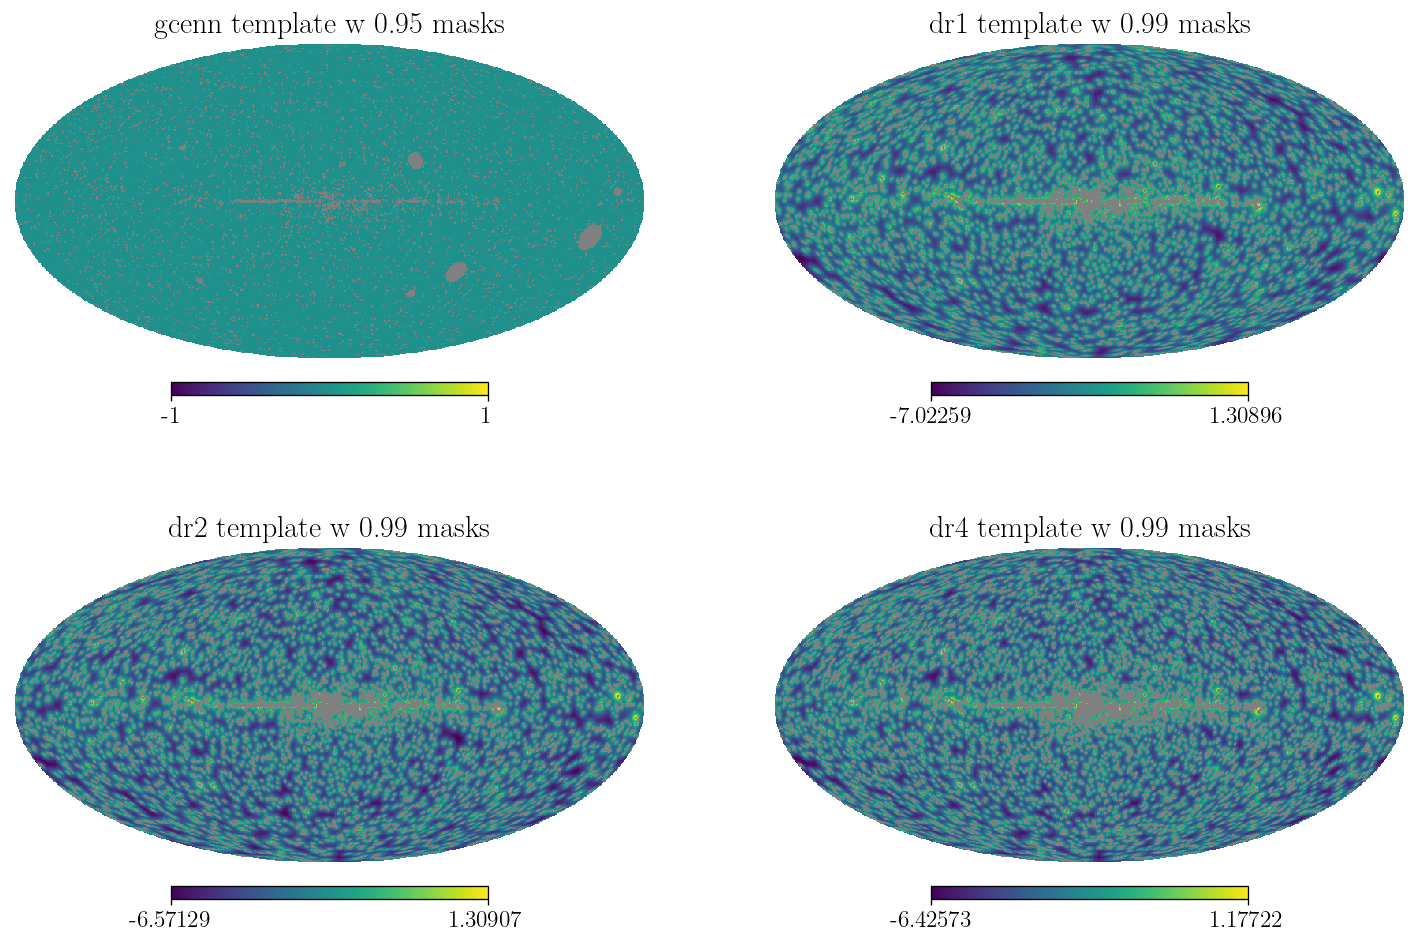

In [94]:
# plots with 99 masks instead
fig, ax_array = plt.subplots(figsize = (15,10), nrows = 2, ncols = 2)

ax1 = ax_array[0,0] ; ax2 = ax_array[0,1] ; ax3 = ax_array[1,0] ; ax4 = ax_array[1,1]

plt.axes(ax1)
hp.mollview(temp_gcenn_95, title="gcenn template w 0.95 masks", hold = True)

plt.axes(ax2)
hp.mollview(np.log10(temp_dr1_99), title="dr1 template w 0.99 masks", hold = True)

plt.axes(ax3)
hp.mollview(np.log10(temp_dr2_99), title="dr2 template w 0.99 masks", hold = True)

plt.axes(ax4)
hp.mollview(np.log10(temp_dr4_99), title="dr4 template w 0.99 masks", hold = True)

In [ ]:
temp_gcenn_dr1m = ef.convert_masked_array_to_hp_array(temp_dr1[~mask_dr2_68], mask_dr2_68, nside=128)

In [ ]:
hp.mollview(np.log10(temp_3fgl), title="3FGL: 2-20 GeV")

In [24]:
temp_4fgl_gcenn = np.load("../data/fermi_data_573w/fermi_data_128/template_psc_4fgl.npy")

In [ ]:
# load new masks
# compare different masking

import astropy.io
from astropy.io import fits

mask_4fgl_mcdermott = np.array(fits.open('../data/masks/4FGL_mcdermott_mask.fits')[0].data, dtype = np.bool_)
mask_4fgl_68 = np.array(fits.open('../data/masks/4FGL_DR4_mask_cl=0.680000.fits')[0].data, dtype = np.bool_)
mask_4fgl_95 = np.array(fits.open('../data/masks/4FGL_DR4_mask_cl=0.950000.fits')[0].data, dtype = np.bool_)
mask_4fgl_99 = np.array(fits.open('../data/masks/4FGL_DR4_mask_cl=0.990000.fits')[0].data, dtype = np.bool_)

nomask = np.array([False for i in range(len(mask_4fgl_mcdermott))])
temp_4fgl_nomask = ef.convert_masked_array_to_hp_array(temp_4fgl, mask = nomask, nside=128)
temp_4fgl_hp_mcdermott = ef.convert_masked_array_to_hp_array(temp_4fgl[~mask_4fgl_mcdermott], mask_4fgl_mcdermott, nside=128)
temp_4fgl_hp_68 = ef.convert_masked_array_to_hp_array(temp_4fgl[~mask_4fgl_68], mask_4fgl_68, nside=128)
temp_4fgl_hp_95 = ef.convert_masked_array_to_hp_array(temp_4fgl[~mask_4fgl_95], mask_4fgl_95, nside=128)
temp_4fgl_hp_99 = ef.convert_masked_array_to_hp_array(temp_4fgl[~mask_4fgl_99], mask_4fgl_99, nside=128)